## Análisis de señales registradas durante sesiones de entrenamiento y calibración

Importamos librerías

In [1]:
from SignalProcessor.Filter import Filter
from TrialsHandler.TrialsHandler import TrialsHandler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#creamos un filtro usando la clase Filter
fm = 250.
filter = Filter(8, 12, 50, 2, fm, 2)

Cargamos los arhchivos del sujeto de testeo

In [3]:
file = "data\darlia_testing\eegdata\sesion2\sn2_ts0_ct1_r1.npy"
rawEEG = np.load(file)

eventosFile = "data\darlia_testing\eegdata\sesion2\sn2_ts0_ct1_r1_events.txt"
eventos = pd.read_csv(eventosFile, sep = ",")

channelsName = ["C3", "CZ", "C4"]

In [4]:
print(rawEEG.shape)

(3, 65650)


Definimos el tiempo mínimo y máximo para analizar

In [5]:
tinit = 0.5 #el tiempo de inicio se considera ANTES del cue
tmax = 4 #el tiempo máximo debe considerarse entre el cue y el final del trial

In [6]:
## Instanciamos la clase TrialsHandler para extraer los trials, labels, nombre de clases, etc.
trialhandler = TrialsHandler(rawEEG, eventos, tinit = tinit, tmax = tmax, reject=None, sample_rate=fm)

Se han extraido 25 trials
Se han extraido 3 canales
Se han extraido 1125 muestras por trial


In [7]:
trialhandler.eventos.head()

,classNumber,className,prediction,probabilities,startingTime,cueDuration,finishDuration,trialTime,trialTime(legible)
trialNumber,,,,,,,,,
1,5,Rest,-1,-1,2.5,4.0,4.0,1.685718e+09,02/06/2023 12:03:33
2,5,Rest,-1,-1,2.7,4.0,4.0,1.685718e+09,02/06/2023 12:03:44
3,2,Mano Derecha,-1,-1,2.7,4.0,4.0,1.685718e+09,02/06/2023 12:03:55
4,4,Pies,-1,-1,2.3,4.0,4.0,1.685718e+09,02/06/2023 12:04:06
5,5,Rest,-1,-1,2.3,4.0,4.0,1.685718e+09,02/06/2023 12:04:16


In [8]:
classesName, classesLabel = trialhandler.classesName #obtenemos el nombre de las clases y sus labels
print(classesName)
labels = trialhandler.labels #obtenemos los labels de cada trial

['Mano Izquierda', 'Mano Derecha', 'Ambas Manos', 'Pies', 'Rest']


### Filtrando señal

Filtramos la señal en la banda $\mu$

In [9]:
mu_trials = filter.fit_transform(trialhandler.trials) #extraemos los trials y los filtramos

print(mu_trials.shape)

(25, 3, 1125)


### Separando cada trial con su clase correspondiente

Para este análisis vamos a formar un array de la forma [clase, n_trials, n_channels, n_samples]. Pero es **importante** tener en cuenta que para el entrenamiento de los algoritmos la forma de los datos es [n_trials, n_channels, n_samples].

In [10]:
trials_x_clase = np.zeros((len(classesName),int(mu_trials.shape[0]/len(classesName)), mu_trials.shape[1], mu_trials.shape[2]))

#Por cada label dentro de classNames, filtramos los trials y lo guardamos en la posición correspondiente dentro de trials
for label in classesLabel:
    trials_x_clase[label-1,:,:,:] = mu_trials[labels == label]

In [11]:
print(trials_x_clase.shape)

(5, 5, 3, 1125)


### Graficando señal

Vamos a graficar la señal para un trial en particular. Además, vamos a marcar la ventana de tiempo en donde la persona realizaba la tarea solicitada.

In [12]:
trial_n = 2 #Selecciono el trial que quiero clasificar
label = labels[trial_n-1] #Obtengo la etiqueta del trial

eventos.index = eventos["trialNumber"]
min_tinit = eventos["startingTime"].min()
startingTime = eventos.loc[trial_n]["startingTime"]
cue_duration = eventos.loc[trial_n]["cueDuration"]
finish_time = eventos.loc[trial_n]["finishDuration"]

trozo_inicial = startingTime - tinit
trozo_final = tmax - cue_duration

Graficamos

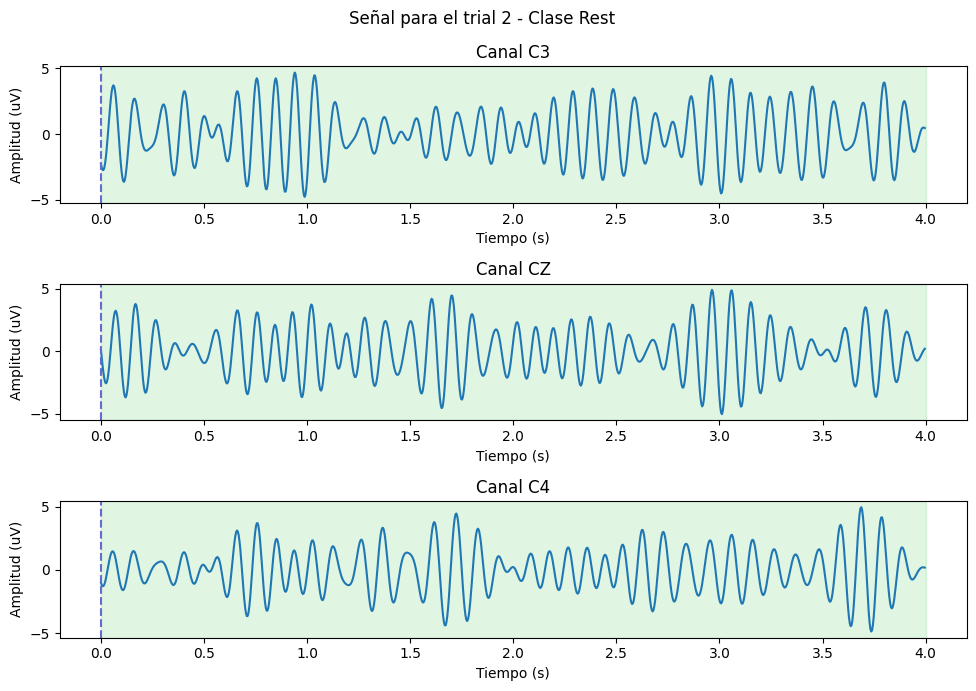

In [13]:
#eje temporal. El mismo va desde -tinit hasta tmax
t = np.arange(-tinit, tmax, 1/250.)

plt.style.use('default')
plt.figure(figsize=(10, 7))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[int(tinit*fm):], trials_x_clase[label-1,trial_n-1, i,int(tinit*fm) :])
    #linea vertical en el tiempo de inicio del cue. Linea punteada
    plt.axvline(x = 0, color="#656ccf", linestyle="--")
    #agrego un rectangulo de color verde con fondo transparente entre el tiempo de inicio del cue y el tiempo del cue
    plt.axvspan(0, cue_duration, color="#65cf70", alpha=0.2)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (uV)")
    plt.title("Canal {}".format(channelsName[i]))

plt.suptitle(f"Señal para el trial {trial_n} - Clase {classesName[classesLabel.index(label)]}")
#dismiuimos el espacio entre subplots
plt.tight_layout()
plt.show()

### Graficos para trials promediados

In [14]:
trials_promedio = trials_x_clase.mean(axis=1)

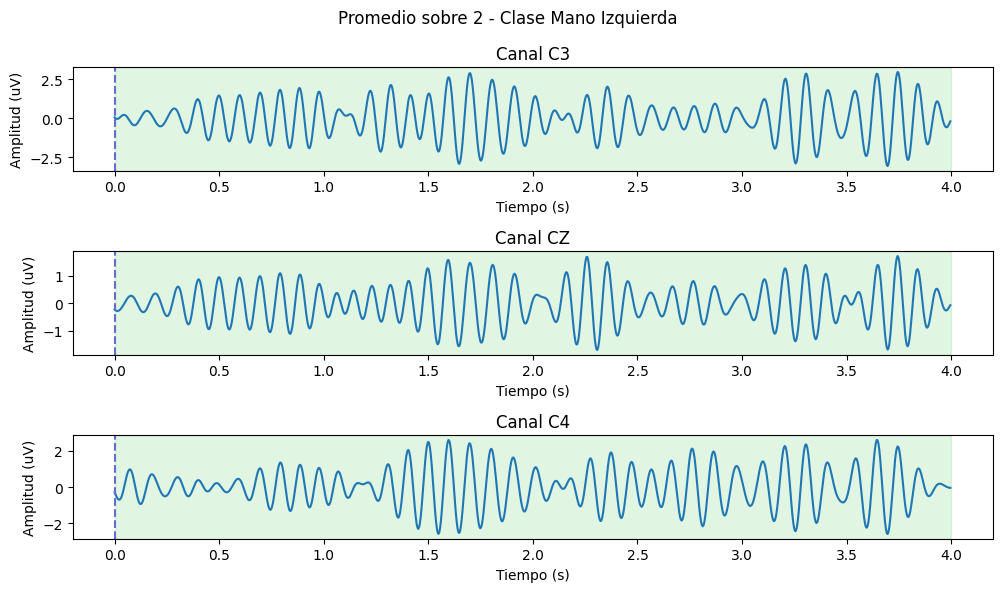

In [15]:
##Grafico tres canales en tres subplots

clase = 1

plt.style.use('default')
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[int(tinit*fm):], trials_promedio[clase-1, i, int(tinit*fm):])
    #linea vertical en el tiempo de inicio del cue. Linea punteada
    plt.axvline(x = 0, color="#656ccf", linestyle="--")
    #agrego un rectangulo de color verde con fondo transparente entre el tiempo de inicio del cue y el tiempo del cue
    plt.axvspan(0, cue_duration, color="#65cf70", alpha=0.2)
    #cambiamos el color del fondo de toda la figura a gris
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (uV)")
    plt.title("Canal {}".format(channelsName[i]))

plt.suptitle(f"Promedio sobre {trial_n} - Clase {classesName[classesLabel.index(clase)]}")
#dismiuimos el espacio entre subplots
plt.tight_layout()
plt.show()

### Extrayendo características

In [16]:
from SignalProcessor.FeatureExtractor import FeatureExtractor
fe_welch = FeatureExtractor(method="welch", sample_rate=250., axisToCompute = 3) #instanciamos el extractor de características

Notar que _axisToCompute = 3_ ya que los datos vienen de la forma [clase, n_trials, n_channels, n_samples]. Lo habitual es _axisToCompute = 2_.

In [17]:
trials_x_clase_welch = fe_welch.fit_transform(trials_x_clase)

Graficamos las características para cada una de las clases y para un trial en particular.

Además, sólo vamos a graficar las frecuencias entre los $5Hz$ y los $28Hz$

In [18]:
trial = 2
freq_indexes = np.where((fe_welch.freqs >= 5) & (fe_welch.freqs <= 20))[0] #obtenemos los índices de las frecuencias entre 5 y 18 Hz

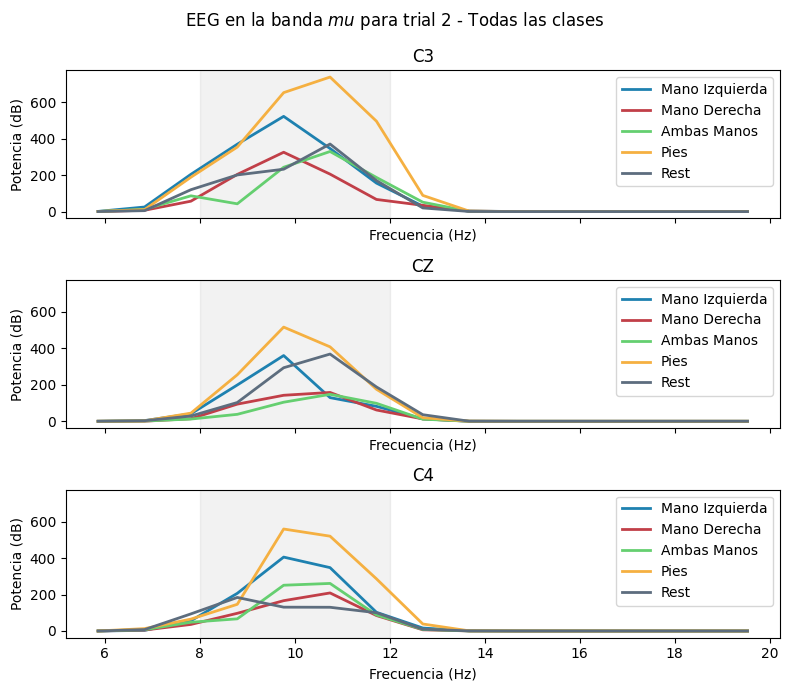

In [19]:
colors = ["#1e81b0", "#c13f48", "#65cf70", "#f5b041", "#5d6d7e"]

fig, axs = plt.subplots(len(channelsName), 1, figsize=(8, 7), sharex=True, sharey=True)
for i, channel in enumerate(channelsName):
    for j, clase in enumerate(classesName):
        axs[i].plot(fe_welch.freqs[freq_indexes], trials_x_clase_welch[j,trial - 1, i, :][freq_indexes], label=clase, linewidth=2, color = colors[j])
        #creamos un rectángulo para resaltar la banda mu
    axs[i].axvspan(8, 12, alpha=0.1, color='grey')
    axs[i].set_title(channel)
    axs[i].set_ylabel('Potencia (dB)')
    axs[i].set_xlabel('Frecuencia (Hz)')
    axs[i].legend()

#reduzco el padding entre subplots
plt.suptitle(f'EEG en la banda $mu$ para trial {trial} - Todas las clases')
plt.tight_layout()
plt.show()

Ahora vamos a graficar las características pero sólo para dos clases. De esta manera, podemos comparar mejor.

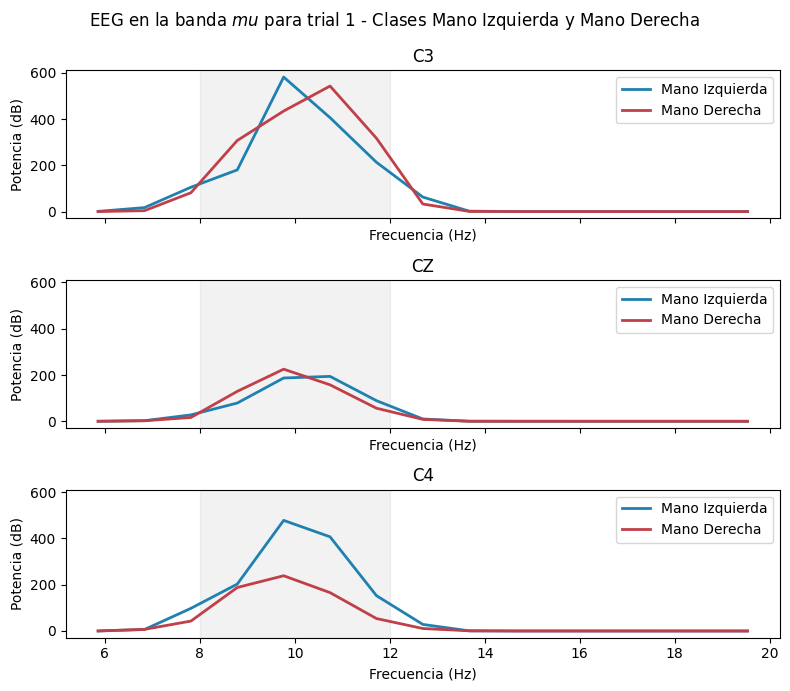

In [20]:
trial = 1
clase1 = 1
clase2 = 2

fig, axs = plt.subplots(len(channelsName), 1, figsize=(8, 7), sharex=True, sharey=True)
for i, channel in enumerate(channelsName):
    axs[i].plot(fe_welch.freqs[freq_indexes], trials_x_clase_welch[clase1-1, trial - 1, i, :][freq_indexes], linewidth=2, color = "#1e81b0")
    axs[i].plot(fe_welch.freqs[freq_indexes], trials_x_clase_welch[clase2-1, trial - 1, i, :][freq_indexes], linewidth=2, color = "#c13f48")
    #creamos un rectángulo para resaltar la banda mu
    axs[i].axvspan(8, 12, alpha=0.1, color='grey')
    axs[i].set_title(channel)
    axs[i].set_ylabel('Potencia (dB)')
    axs[i].set_xlabel('Frecuencia (Hz)')
    axs[i].legend([classesName[clase1-1], classesName[clase2-1]])

#reduzco el padding entre subplots
plt.suptitle(f'EEG en la banda $mu$ para trial {trial} - Clases {classesName[clase1-1]} y {classesName[clase2-1]}')
plt.tight_layout()
plt.show()

### Aplicando CSP a los datos

Ahora vamos a aplicar CSP a nuestros datos.

Importamos la clase _CSPMulticlass_ e instanciamos.

In [21]:
from SignalProcessor.CSPMulticlass import CSPMulticlass
cspmulticlass = CSPMulticlass(n_components=2, method = "ovo", n_classes = len(np.unique(labels)), reg = 0.01)

Separamos los datos en entrenamiento y test

In [22]:
## Separamos en train y test
from sklearn.model_selection import train_test_split
#separamos en train y test. Balanceamos las clases
X_train, X_test, y_train, y_test = train_test_split(mu_trials, labels, test_size=0.2, random_state=42, stratify=labels)

Generamos los filtros espaciales.

In [23]:
#entrenamos el CSP
cspmulticlass.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.18 (2.2e-16 eps * 3 dim * 2.7e+14  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.21 (2.2e-16 eps * 3 dim * 3.1e+14  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.21 (2.2e-16 eps * 3 dim * 3.2e+14  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.21 (2.2e-16 eps * 3 dim * 3.1e+14  max singular value)
    Estimated rank (mag): 3
   

CSPMulticlass(reg=0.01)

Aplicamos el CSP a los trials para ver si mejora la separación entre clases.

In [24]:
## Aplico CSP a mu_trials
mu_trials_csp = cspmulticlass.transform(mu_trials)
print(mu_trials_csp.shape)

(25, 20, 1125)


In [25]:
fe_welch = FeatureExtractor(method="welch", sample_rate=250., axisToCompute = 2, band_values=[5,18]) #instanciamos el extractor de características
mu_trials_csp_welch = fe_welch.fit_transform(mu_trials_csp)
print(mu_trials_csp_welch.shape)

(25, 20, 13)


### Unificando componentes

Vamos a unificar cada componente obtenida desde el CSP en una sóla. De esta manera, podemos analizar cómo se distribuyen las características para cada clase y así podemos compararlas.

In [26]:
from SignalProcessor.RavelTransformer import RavelTransformer
raveltransformer = RavelTransformer() #instanciamos el raveltransformer

In [27]:
mu_trials_csp_welch_ravel = raveltransformer.fit_transform(mu_trials_csp_welch)
print(mu_trials_csp_welch_ravel.shape)

(25, 260)


Ahora vamos a graficar algunas de las características que hemos obtenido para la clase Mano Izquierda (label = 1) y clase Mano Derecha (label = 2).

In [28]:
## Reordenamos los trials para que queden en la forma [clase, n_trials, n_features]. Usamos labels para reordenar

trials_csp_welch_ravel = np.zeros((len(classesName),int(mu_trials_csp_welch_ravel.shape[0]/len(classesName)), mu_trials_csp_welch_ravel.shape[1]))

#Por cada label dentro de classNames, filtramos los trials y lo guardamos en la posición correspondiente dentro de trials
for label in classesLabel:
    trials_csp_welch_ravel[label-1,:,:] = mu_trials_csp_welch_ravel[labels == label]

print(trials_csp_welch_ravel.shape)   

(5, 5, 260)


In [29]:
#Formamos un array con el trial uno de cada clase
trial = 1
trial1_clases = trials_csp_welch_ravel[:,trial-1,:]
print(trial1_clases.shape) 

## Contacatenamos los trials de cada clase

(5, 260)


Graficamos

[]

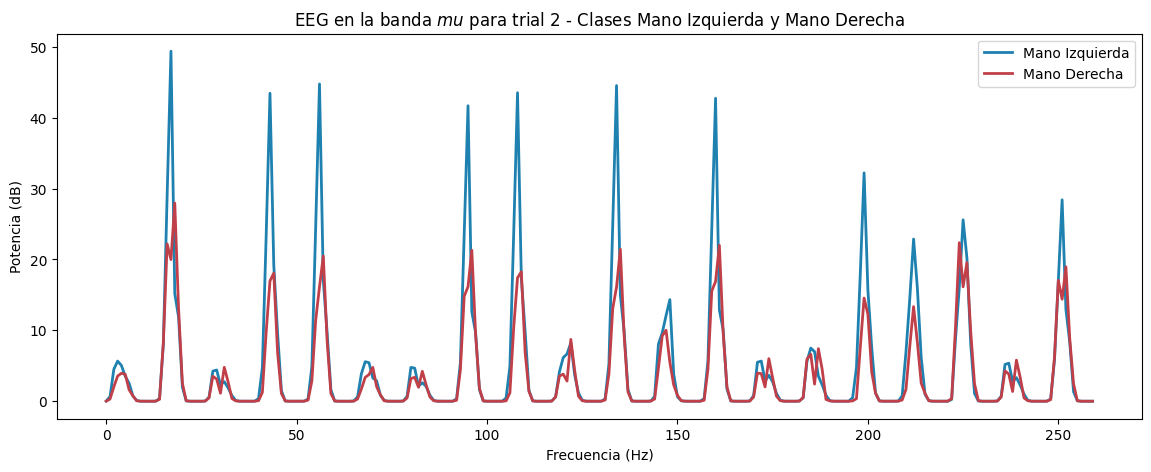

In [30]:
trial = 2
clase1 = 1
clase2 = 2

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(trials_csp_welch_ravel[clase1-1, trial - 1, :], linewidth=2, color = "#1e81b0", label = classesName[clase1-1])
ax.plot(trials_csp_welch_ravel[clase2-1, trial - 1, :], linewidth=2, color = "#c13f48", label = classesName[clase2-1])
ax.set_ylabel('Potencia (dB)')
ax.set_xlabel('Frecuencia (Hz)')
ax.legend()
plt.title(f'EEG en la banda $mu$ para trial {trial} - Clases {classesName[clase1-1]} y {classesName[clase2-1]}')
plt.plot()

### Conclusión de la figura anterior

Entendiendo que _CSPMulticlass_ al ser entrenada con el parámetro _ovo_ es decir _one vs one_, estaremos entrenando un total de $ n_{filters} = \frac{n_{clases}\times(n_{clases})}{2}$, luego si $n_{clases} = 5$ tendremos $n_{filters} = 10$. Luego, si la cantidad de componentes seleccionada es $2$ la clase _CSPMulticlass_ nos retornará un total de $2\times10 = 20$ componentes, es decir, dos componentes por cada filtro entrenado.

Por lo tanto, por cada señal de entrada a `CSPMulticlass.transform()` de la forma _[n_trials, n_channels, n_samples]_ obtendremos una salida equivalente a _[n_trials, n_components, n_samples]_.

Luego cuando extraemos las características, estamos extrayendo las componentes frecuenciales de cada componente de EEG habiendo sido proyectado al nuevo espaco. Finalmente y para poder luego usar las características en un clasificador, es que unificamos (usando _Ravel_) en una sóla componente cada una de las componentes obtenidas.

Podemos ver que las características entre las clases Mano Izquierda y Mano Derecha son diferentes.

## Usando _pipeline()_ para clasificar la señal

Vamos a utilizar el método _Pipeline_ de Skit-Learn para generar un pipeline que tome la señal de EEG cruda, la filtre, obtenga los filtros aplicando CSPMulticlass, realice la extracción de características con FeatureExtractor, aplique el RavelTransformer y clasifique con un LDA.

In [31]:
from TrialsHandler.TrialsHandler import TrialsHandler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Cargamos los datos

In [32]:
fm = 250.
file = "data\pablo_testing\eegdata\sesion1\sn1_ts0_ct1_r2.npy"
rawEEG = np.load(file)

eventosFile = "data\pablo_testing\eegdata\sesion1\sn1_ts0_ct1_r2_events.txt"
eventos = pd.read_csv(eventosFile, sep = ",")

channelsName = ["C3", "CZ", "C4"]
tinit = 0.5 #el tiempo de inicio se considera ANTES del cue
tmax = 4 #el tiempo máximo debe considerarse entre el cue y el final del trial
## Instanciamos la clase TrialsHandler para extraer los trials, labels, nombre de clases, etc.
trialhandler = TrialsHandler(rawEEG, eventos, tinit = tinit, tmax = tmax, reject=None, sample_rate=fm)

classesName, classesLabel = trialhandler.classesName #obtenemos el nombre de las clases y sus labels
print(classesName)
labels = trialhandler.labels #obtenemos los labels de cada trial

Se han extraido 25 trials
Se han extraido 3 canales
Se han extraido 1125 muestras por trial
['Mano Izquierda', 'Mano Derecha', 'Ambas Manos', 'Pies', 'Rest']


### Instanciamos las clases a utilizar en el Pipeline

In [33]:
from SignalProcessor.Filter import Filter
from SignalProcessor.FeatureExtractor import FeatureExtractor
from SignalProcessor.CSPMulticlass import CSPMulticlass
from SignalProcessor.RavelTransformer import RavelTransformer

In [34]:
filter = Filter(lowcut=8, highcut=12, notch_freq=50.0, notch_width=2, sample_rate=fm, axisToCompute=2, padlen=None, order=4)
#Creamos un CSPMulticlass - Método ovo (one vs one)
cspmulticlass = CSPMulticlass(n_components=2, method = "ova", n_classes = len(np.unique(labels)), reg = 0.01)
featureExtractor = FeatureExtractor(method = "welch", sample_rate = fm, axisToCompute=2, band_values=[5,18])
ravelTransformer = RavelTransformer()

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA() #instanciamos el clasificador LDA

In [35]:
from sklearn.pipeline import Pipeline

Generamos pipeline

In [36]:
#Vamos a probar un LDA
pipeline_lda = Pipeline([
    ('pasabanda', filter),
    ('cspmulticlase', cspmulticlass),
    ('featureExtractor', featureExtractor),
    ('ravelTransformer', ravelTransformer),
    ('lda', lda)
])

In [37]:
trials_raw = trialhandler.trials
print(trials_raw.shape)

(25, 3, 1125)


In [38]:
## dividimos raw_eeg en train y test
from sklearn.model_selection import train_test_split
#separamos en train y test. Balanceamos las clases
X_train, X_test, y_train, y_test = train_test_split(trials_raw, labels, test_size=0.2, random_state=42, stratify=labels)

Entrenamos el Pipeline

In [39]:
## Entrenamos el pipeline_lda

pipeline_lda.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.38 (2.2e-16 eps * 3 dim * 5.8e+14  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.91 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.2 (2.2e-16 eps * 3 dim * 3e+14  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.96 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MA

Pipeline(steps=[('pasabanda', Filter(highcut=12, lowcut=8, notch_width=2)),
                ('cspmulticlase', CSPMulticlass(method='ova', reg=0.01)),
                ('featureExtractor', FeatureExtractor(band_values=[5, 18])),
                ('ravelTransformer', RavelTransformer()),
                ('lda', LinearDiscriminantAnalysis())])

### Usamos pipeline_lda

Ahora vamos a usar _pipeline_lda_ para clasificar los datos de testeo

In [40]:
## Ahora vamos a usar _pipeline_lda_ para clasificar los datos de testeo

y_pred = pipeline_lda.predict(X_test)

## Calculamos la accuracy

from sklearn.metrics import accuracy_score
print(f"Accu: {accuracy_score(y_test, y_pred)*100}%")

Accu: 80.0%


### Pipeline con SVM

In [41]:
## Generamos un Pipeline para clasificar con un clasificador SVM
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=0.1, probability=True) #instanciamos el clasificador SVM

#Vamos a probar un LDA
pipeline_svm = Pipeline([
    ('pasabanda', filter),
    ('cspmulticlase', cspmulticlass),
    ('featureExtractor', featureExtractor),
    ('ravelTransformer', ravelTransformer),
    ('svm', svm)
])

In [42]:
## Entrenamos el pipeline_svm
pipeline_svm.fit(X_train, y_train)


Computing rank from data with rank=None
    Using tolerance 0.38 (2.2e-16 eps * 3 dim * 5.8e+14  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.91 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.2 (2.2e-16 eps * 3 dim * 3e+14  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.96 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MA

Pipeline(steps=[('pasabanda', Filter(highcut=12, lowcut=8, notch_width=2)),
                ('cspmulticlase', CSPMulticlass(method='ova', reg=0.01)),
                ('featureExtractor', FeatureExtractor(band_values=[5, 18])),
                ('ravelTransformer', RavelTransformer()),
                ('svm', SVC(C=0.1, kernel='linear', probability=True))])

In [43]:
## Ahora vamos a usar _pipeline_svm_ para clasificar los datos de testeo
y_pred = pipeline_svm.predict(X_test)

## Calculamos la accuracy
accuracy_score(y_test, y_pred)

0.4